In [113]:
import os
import torch
import torchvision
import PIL.Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Dataset from: https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

In [63]:
DATA_DIRECTORY = "./nyu_depth_data"
!ls -al {DATA_DIRECTORY}

total 4348
drwxr-xr-x   4 archnick users    4096 Mar  9 15:30 ./
drwxr-xr-x   3 archnick users    4096 Mar  9 15:31 ../
drwxr-xr-x   2 archnick users   45056 Mar  9 15:30 nyu2_test/
-rw-r--r--   1 archnick users   41202 Mar  7  2021 nyu2_test.csv
drwxr-xr-x 286 archnick users   12288 Mar  9 15:31 nyu2_train/
-rw-r--r--   1 archnick users 4333872 Mar  9 15:40 nyu2_train.csv


In [60]:
def parse_csv(raw_csv):
    lines = raw_csv.split("\n")
    lines.remove("")
    data = [row.split(",") for row in lines]
    return data

In [61]:
index_csv_train = os.path.join(DATA_DIRECTORY, "nyu2_train.csv")
index_csv_test = os.path.join(DATA_DIRECTORY, "nyu2_test.csv")

index_df_train = pd.DataFrame(
    columns=["image", "mask"],
    data=parse_csv(open(index_csv_train, "r").read())
)

index_df_test = pd.DataFrame(
    columns=["image", "mask"],
    data=parse_csv(open(index_csv_test, "r").read())
)

In [65]:
list(index_df_train.iloc[100])

['data/nyu2_train/living_room_0038_out/69.jpg',
 'data/nyu2_train/living_room_0038_out/69.png']

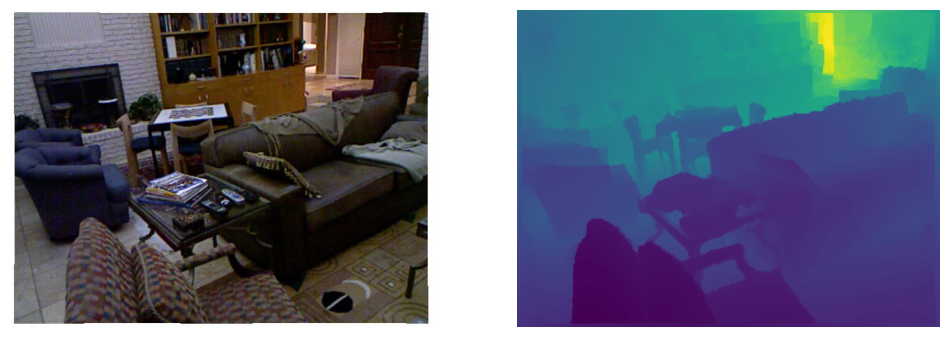

In [62]:
sample_index = list(index_df_train.iloc[100])
sample_index[0] = os.path.join(DATA_DIRECTORY, sample_index[0][5:])
sample_index[1] = os.path.join(DATA_DIRECTORY, sample_index[1][5:])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(PIL.Image.open(sample_index[0]))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(PIL.Image.open(sample_index[1]))
plt.axis(False)

plt.show()

In [114]:
class NYUDepthDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, csv_index, transform=None):
        self.root_dir = root_dir
        self.csv_index = os.path.join(root_dir, csv_index)
        self.transform = transform

        self.index_df = self.load_csv_index(self.csv_index)
    
    def parse_csv(self, raw_csv):
        lines = raw_csv.split("\n")
        lines.remove("")
        data = [row.split(",") for row in lines]
        return data
    
    def change_index_path(self, path):
        # Before: data/nyu2_train/living_room_0038_out/69.jpg
        # After: nyu_depth_data/nyu2_train/living_room_0038_out/69.jpg
        return os.path.join(self.root_dir, path.strip("data/"))

    def load_csv_index(self, path):
        data = self.parse_csv(open(path, "r").read())

        for row in range(len(data)):
            for col in range(len(data[row])):
                data[row][col] = self.change_index_path(data[row][col])

        index_df = pd.DataFrame(
            columns=["image", "mask"],
            data=data
        )

        return index_df

    def __len__(self):
        return len(self.index_df)

    def __getitem__(self, index):
        image_path, mask_path = list(self.index_df.iloc[index])
        image, mask = PIL.Image.open(image_path), PIL.Image.open(mask_path)

        if self.transform != None:
            image, mask = self.transform(image), self.transform(mask)

        return image, mask

In [120]:
basic_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor()
])

dataset = NYUDepthDataset(
    root_dir=DATA_DIRECTORY,
    csv_index="nyu2_train.csv",
    transform=basic_transform
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

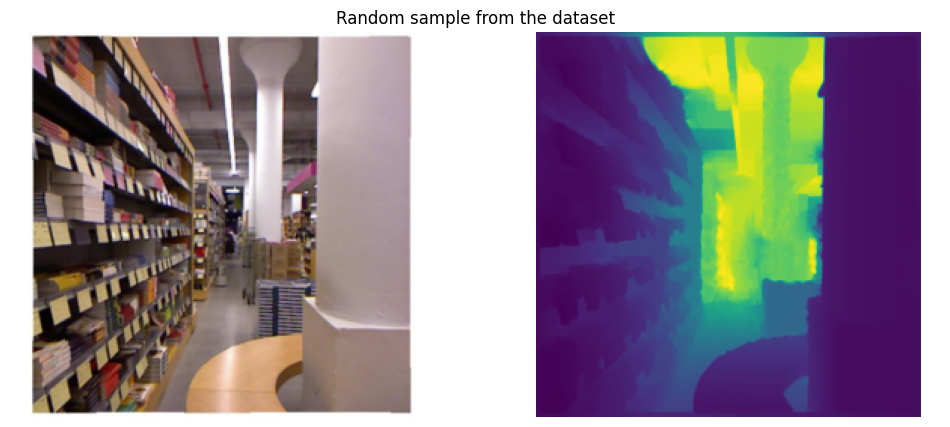

In [131]:
# X_batch - (64, 3, 256, 256)
# y_batch - (64, 1, 256, 256)
X_batch, y_batch = next(iter(dataloader))

plt.figure(figsize=(12, 5))
plt.title("Random sample from the dataset")
plt.axis(False)

plt.subplot(1, 2, 1)
plt.imshow(X_batch[0].permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(y_batch[0].permute(1, 2, 0))
plt.axis(False)

plt.show()